# Preparing MNIST data 

In [160]:
from pathlib import Path
import requests   
import pickle
import gzip
import matplotlib.pyplot as plt


In [161]:
data_path=Path("data") if Path("data").exists() else Path("../data")
path=data_path/"vector-mnist"
path.mkdir(parents=True,exist_ok=True)

In [162]:
path

WindowsPath('data/vector-mnist')

In [163]:
def download_mnist(path):
    url = "https://github.com/pytorch/tutorials/raw/main/_static/"
    filename = "mnist.pkl.gz"

    if not (path / filename).exists():
        content = requests.get(url + filename).content
        (path / filename).open("wb").write(content)

    return path / filename


data_path = Path("data") if Path("data").exists() else Path("../data")
path = data_path / "downloaded" / "vector-mnist"
path.mkdir(parents=True, exist_ok=True)

datafile = download_mnist(path)

In [164]:
def read_mnist(path):
    with gzip.open(path, "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
    return x_train, y_train, x_valid, y_valid

x_train, y_train, x_valid, y_valid = read_mnist(datafile)

The data type is numpy array, for the rest of the lab we will be using torch.tensors as they store gradients and graph structure.

In [165]:
import torch 
x_train, y_train, x_valid, y_valid=map(torch.tensor, (x_train, y_train, x_valid, y_valid))

In [166]:
x_train,y_train

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4,  ..., 8, 4, 8]))

In [167]:
y_train.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

The corresponding label is 5


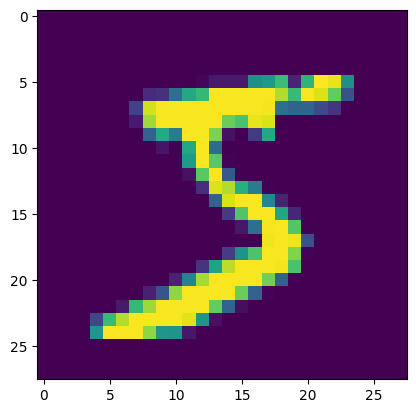

In [168]:
plt.imshow(x_train[0].reshape(28,28))
print(f'The corresponding label is {y_train[0]}')

# Mnist classification with DNN

## Building a DNN using only torch.Tensor methods and Python

Lets create a function that fetch batchs to use for training

In [169]:
import random
bs=32
def get_batch(x,y):
    # batch size
    
    # generate a random integer i
    i=random.randint(1,x_train.shape[0]-bs)
    # get train batch 
    return x[i:i+bs],y[i:i+bs]

X,Y=get_batch(x_train,y_train)

print(f" X: {X.shape} and Y: {Y.shape} shapes are")


 X: torch.Size([32, 784]) and Y: torch.Size([32]) shapes are


Lets define the DNN parameters: W (weight) and b (bias).

In [170]:
W = torch.rand(784, 10, requires_grad=True)
b=torch.rand(10,requires_grad=True)
parameters=[W,b]


### Defining the model

In [171]:
(X@W).shape,b.shape

(torch.Size([32, 10]), torch.Size([10]))

In [172]:
logits=(X@W)+b # (32,10)
logits=logits-logits.max(dim=1, keepdim=True)[0]
exp_logits=logits.exp() # (32,10)
sum_logits=exp_logits.sum(1,keepdim=True) # (32,1)
proba=exp_logits/sum_logits
# Calculate negative log likelihood
nll = -torch.log(proba[torch.arange(bs), Y])
# Average over the batch
loss = nll.mean()
loss

tensor(3.4879, grad_fn=<MeanBackward0>)

In [173]:
def model(X,Y):
    logits=(X@W)+b # (32,10)
    logits=logits-logits.max(dim=1, keepdim=True)[0]
    exp_logits=logits.exp() # (32,10)
    sum_logits=exp_logits.sum(1,keepdim=True) # (32,1)
    proba=exp_logits/sum_logits
    return logits,proba
    

### Defining the loss and metrics

In [174]:
import torch.nn.functional as F
loss=F.cross_entropy(logits,Y)
loss

tensor(3.4879, grad_fn=<NllLossBackward0>)

In [175]:
logits,proba=model(x_train,y_train)

In [176]:
accuracy=torch.mean(((torch.argmax(proba, 1, keepdim=False)==y_train)*1).float())
accuracy

tensor(0.1083)

### Defining and running the fitting loop 

In [177]:
epoch=100
lr=0.1
for _ in range(epoch):
    X,Y=get_batch(x_train,y_train)
    # forward pass
    logits,proba=model(X,Y)
    loss=F.cross_entropy(logits,Y)
    # backward pass
    loss.backward()
    # update parameters
    # Weight W
    with torch.no_grad():
        W+=-lr*W.grad
        #update bias b
        b+=-lr*b.grad
        # zeroing the gradients
        W.grad.zero_()
        b.grad.zero_()

print(loss)

tensor(0.7815, grad_fn=<NllLossBackward0>)


In [178]:
logits,proba=model(x_valid,y_valid)
accuracy=torch.mean(((torch.argmax(proba, 1, keepdim=False)==y_valid)*1).float())
accuracy

tensor(0.7413)

# Refactoring with core torch.nn components

## Using torch.nn.Module to define functions whose state is given by torch.nn.Parameters

In [179]:
a=x_train[1]


In [180]:
class logisticRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.ln=torch.nn.Linear(784,10)
        
    def forward(self,x):
        x=self.ln(x)
        x = F.softmax(x, dim=1)
        return x


In [181]:
model=logisticRegression()
loss_func=F.cross_entropy
accuracy= lambda proba,y :torch.mean(((torch.argmax(proba, 1, keepdim=False)==y)*1).float())


In [182]:
loss_func(model(X),Y)# batch loss

tensor(2.3050, grad_fn=<NllLossBackward0>)

In [185]:
epoch=100

lr=0.1
for _ in range(epoch):
    xb,yb=get_batch(x_train,y_train)
    loss=loss_func(model(xb),yb)
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p-=lr*p.grad
    
print("validation loss",loss_func(model(x_valid),y_valid))
print("accuracy on validation", accuracy(model(x_valid),y_valid))

validation loss tensor(1.5880, grad_fn=<NllLossBackward0>)
accuracy on validation tensor(0.8722)


# Refactoring intermediate torch.nn components: network layers, optimizers, and data handling

## Applying gradients with torch.optim.Optimizer

In [215]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.ln=torch.nn.Linear(784,10)
            
    def forward(self,x):
        x=self.ln(x)
        x=F.softmax(x,1)
        return x

In [216]:
m=MLP()
opt=torch.optim.Adam(m.parameters())


In [218]:
epoch=1000

lr=0.1
for _ in range(epoch):
    xb,yb=get_batch(x_train,y_train)
    loss=loss_func(m(xb),yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
    
print("validation loss",loss_func(m(x_valid),y_valid))
print("accuracy on validation", accuracy(m(x_valid),y_valid))

validation loss tensor(1.5889, grad_fn=<NllLossBackward0>)
accuracy on validation tensor(0.9080)


## Organizing data with torch.utils.data.Dataset

## Batching up data with torch.utils.data.DataLoader

In [235]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds=TensorDataset(x_train,y_train)

In [223]:
len(train_ds)

50000

In [252]:
train_dl=DataLoader(train_ds, batch_size=10000)

AttributeError: 'MLP' object has no attribute 'fit'